<a href="https://colab.research.google.com/github/gokul-pv/ModelAndDataDrift/blob/main/DriftDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up model, dataloader and training loop

In [ ]:
!nvidia-smi

Mon Nov 28 16:40:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install --quiet alibi-detect[torch] albumentations torchdrift tensorboard

     |████████████████████████████████| 306 kB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 62.0 MB/s 
     |████████████████████████████████| 5.5 MB 47.9 MB/s 
     |████████████████████████████████| 34.5 MB 6.3 kB/s 
     |████████████████████████████████| 182 kB 42.3 MB/s 
     |████████████████████████████████| 7.6 MB 10.8 MB/s 


In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
%load_ext tensorboard

**DataLoader**

In [ ]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

train_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(channel_means, channel_stdevs),
            ]
        )
# Test Phase transformations
test_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(channel_means, channel_stdevs),
            ]
        )


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda' if cuda else 'cpu')

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


Model Creation

In [ ]:
! git clone https://github.com/gokul-pv/MyMainRepo

Cloning into 'MyMainRepo'...
remote: Enumerating objects: 229, done.
remote: Total 229 (delta 0), reused 0 (delta 0), pack-reused 229
Receiving objects: 100% (229/229), 59.35 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
from MyMainRepo.models import sample_net

In [ ]:
model = sample_net()

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = model.to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
    

In [ ]:
#Training & Testing Loops
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

def train(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  
  correct = 0
  processed = 0
  train_loss = 0

  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader.dataset)    
  train_losses.append(train_loss)
  train_accuracy.append(100. * correct / len(train_loader.dataset)) 


In [ ]:
def test(model, device, criterion, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

**Training without augmentations**

In [ ]:
MEAN = torch.tensor([0.4919, 0.4827, 0.4472])
STD = torch.tensor([0.2470, 0.2434, 0.2616])

In [ ]:
EPOCHS = 20

writer = SummaryWriter()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'Learning Rate:', optimizer.param_groups[0]['lr'])

    images, labels = next(iter(trainloader))
    # print(images.shape)
    images = images.to(device) * STD[:, None, None].to(device) + MEAN[:, None, None].to(device)
    grid = torchvision.utils.make_grid(images[:25], nrow=5)
    writer.add_image('Training images', grid, epoch)

    train(model, device, trainloader, optimizer, criterion, epoch)
    test(model, device, criterion, testloader)


writer.add_graph(model, images)
writer.flush()
writer.close()

EPOCH: 1 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5656/10000 (56.56%)

EPOCH: 2 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6361/10000 (63.61%)

EPOCH: 3 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7128/10000 (71.28%)

EPOCH: 4 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7382/10000 (73.82%)

EPOCH: 5 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7573/10000 (75.73%)

EPOCH: 6 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7822/10000 (78.22%)

EPOCH: 7 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7979/10000 (79.79%)

EPOCH: 8 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8031/10000 (80.31%)

EPOCH: 9 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8093/10000 (80.93%)

EPOCH: 10 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8022/10000 (80.22%)

EPOCH: 11 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8154/10000 (81.54%)

EPOCH: 12 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8215/10000 (82.15%)

EPOCH: 13 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8289/10000 (82.89%)

EPOCH: 14 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8173/10000 (81.73%)

EPOCH: 15 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8158/10000 (81.58%)

EPOCH: 16 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8296/10000 (82.96%)

EPOCH: 17 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8308/10000 (83.08%)

EPOCH: 18 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8265/10000 (82.65%)

EPOCH: 19 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8287/10000 (82.87%)

EPOCH: 20 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8325/10000 (83.25%)



In [ ]:
torch.save(model, "weight.pth")

In [ ]:
# model = torch.load("weight.pth")

# Maximum Mean Discrepancy (MMD)

In [ ]:
from functools import partial
import albumentations as A
from albumentations.pytorch import ToTensorV2

from alibi_detect.cd import MMDDrift
from alibi_detect.cd.pytorch import preprocess_drift

In [ ]:
cifar10_test_ds = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=test_transforms)
print(len(cifar10_test_ds))

Files already downloaded and verified
10000


Splitting the CIFAR10 test set into two groups

In [ ]:
test_ref, test_ref_h0 = torch.utils.data.random_split(cifar10_test_ds, (5_000, 5_000), )
print(len(test_ref), len(test_ref_h0))

5000 5000


In [ ]:
test_ref_data, test_ref_data_h0 = next(iter(torch.utils.data.DataLoader(test_ref, batch_size=5_000, shuffle=False))), \
                                  next(iter(torch.utils.data.DataLoader(test_ref_h0, batch_size=5_000, shuffle=False)))

In [ ]:
print(test_ref_data[0].shape, test_ref_data[1].shape)
print(test_ref_data_h0[0].shape, test_ref_data_h0[1].shape)

torch.Size([5000, 3, 32, 32]) torch.Size([5000])
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


Checking the class distribution of split

In [ ]:
# n_test = test_ref_data_h0[0].shape[0]
classess, counts_ref = np.unique(test_ref_data[1], return_counts=True)
counts_h0 = np.unique(test_ref_data_h0[1], return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classess, counts_ref, counts_h0):
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     524 476
1     503 497
2     479 521
3     535 465
4     478 522
5     505 495
6     489 511
7     504 496
8     479 521
9     504 496


Setting up the MMD drift detector with **test_ref_data** group as reference data

In [ ]:
preprocess_fn = partial(preprocess_drift, model=model, device=device, batch_size=128)

In [ ]:
cd = MMDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

Checking the prediction for original image from test_ref_data_h0 group

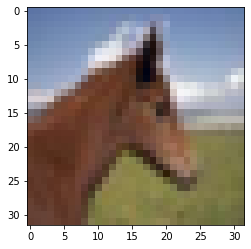

In [ ]:
plt.imshow(
    torch.tensor(test_ref_data_h0[0][10].numpy() * STD[:, None, None].numpy() + MEAN[:, None, None].numpy()).permute(1, 2, 0)
)
plt.show()

In [ ]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

pred = torch.argmax(model(test_ref_data_h0[0][10][None, ...].to(device)), dim=-1)
print(f"Prediction:{classes[pred.item()]}")

Prediction:horse


Applying some pertubation to original image and checking the predictions

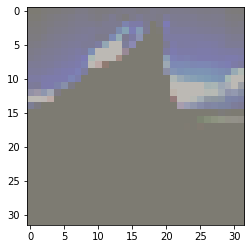

In [ ]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=1.5,
    contrast_limit=0.9,
    p=1
)

perturbed_image = torch.tensor(perturb(image=test_ref_data_h0[0][10].numpy(),)['image'])

plt.imshow(
    (perturbed_image* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0)
)
plt.show()

In [ ]:
pred = torch.argmax(model(perturbed_image[None, ...].to(device)), dim=-1)
print(f"Prediction:{classes[pred.item()]}")

Prediction:ship


Checking if the data has dfrited by comparing for the original test set **test_ref_data_h0** with reference **test_ref_data**

In [ ]:
cd.predict(test_ref_data_h0[0][:100])

{'data': {'is_drift': 0,
  'distance': -0.002507328987121582,
  'p_val': 0.7900000214576721,
  'threshold': 0.05,
  'distance_threshold': array(0.00439334, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is **No Drift!!!**

Checking if the data has dfrited after applying random brighness and contrast to  **test_ref_data_h0**

In [ ]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

Pertubed image

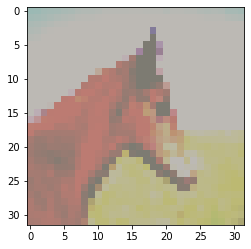

In [ ]:
plt.imshow((perturbed_images[10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

original image

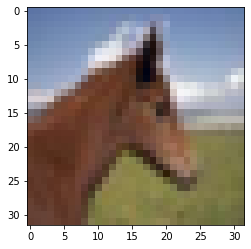

In [ ]:
plt.imshow((test_ref_data_h0[0][10] * STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

In [ ]:
cd.predict(perturbed_images[:100])

{'data': {'is_drift': 1,
  'distance': 0.1609412431716919,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00813687, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is some **drift** in data here

Applying some Noise and checking for drift

In [ ]:
perturb = A.GaussNoise(p=0.55)
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

Pertubed image

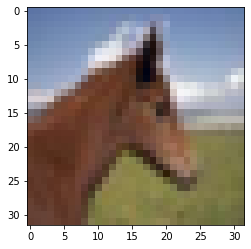

In [ ]:
plt.imshow((perturbed_images[10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

original image

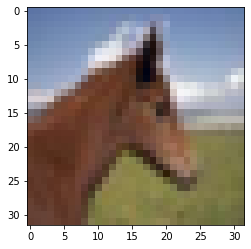

In [ ]:
plt.imshow((test_ref_data_h0[0][10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

In [ ]:
cd.predict(perturbed_images[:100])

{'data': {'is_drift': 1,
  'distance': 0.12979304790496826,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00495988, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is **some drift**

# Model trained with augmentation

In [ ]:
class AlbumentationTransforms:

  """
  Helper class to create test and train transforms using Albumentations
  """

  def __init__(self, transforms_list):
    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img)
    return self.transforms(image=img)['image']



In [ ]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

train_transforms = AlbumentationTransforms(
        [
            A.Normalize(mean=channel_means, std=channel_stdevs),
            A.GaussNoise(p=0.2),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            ToTensorV2()
        ]
    )

# Test Phase transformations
test_transforms = AlbumentationTransforms(
        [
            A.Normalize(mean=channel_means, std=channel_stdevs),
            ToTensorV2(),
        ]
    )

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda' if cuda else 'cpu')

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


In [ ]:
model_aug = sample_net().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

In [ ]:
EPOCHS = 20
MEAN = torch.tensor([0.4919, 0.4827, 0.4472])
STD = torch.tensor([0.2470, 0.2434, 0.2616])

writer = SummaryWriter()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'Learning Rate:', optimizer.param_groups[0]['lr'])
    images, labels = next(iter(trainloader))
    # print(images.shape)
    images = images.to(device) * STD[:, None, None].to(device) + MEAN[:, None, None].to(device)
    grid = torchvision.utils.make_grid(images[:25], nrow=5)
    writer.add_image('Training images', grid, epoch)

    train(model_aug, device, trainloader, optimizer, criterion, epoch)
    test(model_aug, device, criterion, testloader)

writer.add_graph(model_aug, images)
writer.flush()
writer.close()

EPOCH: 1 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4823/10000 (48.23%)

EPOCH: 2 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 5323/10000 (53.23%)

EPOCH: 3 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 6277/10000 (62.77%)

EPOCH: 4 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6549/10000 (65.49%)

EPOCH: 5 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6896/10000 (68.96%)

EPOCH: 6 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7054/10000 (70.54%)

EPOCH: 7 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7292/10000 (72.92%)

EPOCH: 8 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7411/10000 (74.11%)

EPOCH: 9 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7496/10000 (74.96%)

EPOCH: 10 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7564/10000 (75.64%)

EPOCH: 11 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7583/10000 (75.83%)

EPOCH: 12 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7687/10000 (76.87%)

EPOCH: 13 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7799/10000 (77.99%)

EPOCH: 14 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7833/10000 (78.33%)

EPOCH: 15 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7954/10000 (79.54%)

EPOCH: 16 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7884/10000 (78.84%)

EPOCH: 17 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7922/10000 (79.22%)

EPOCH: 18 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7919/10000 (79.19%)

EPOCH: 19 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7980/10000 (79.80%)

EPOCH: 20 Learning Rate: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7995/10000 (79.95%)



In [28]:
torch.save(model_aug, "weight_aug.pth")

In [ ]:
# model_aug = torch.load("weight_aug.pth")

Creating reference data for MMD drift detection by using training data 

In [29]:
cifar10_test_ds_aug = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=train_transforms)
print(len(cifar10_test_ds_aug))

Files already downloaded and verified
50000


In [30]:
test_ref_data_aug = next(iter(torch.utils.data.DataLoader(cifar10_test_ds_aug, batch_size=10_000, shuffle=False)))
                               

In [31]:
print(test_ref_data_aug[0].shape, test_ref_data_aug[1].shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


Checking the class distribution of sampled training images

In [32]:
classess, counts_ref = np.unique(test_ref_data_aug[1], return_counts=True)
print('Class Ref H0')
for cl, cref in zip(classess, counts_ref):
    print('{}     {}'.format(cl, cref))

Class Ref H0
0     1005
1     974
2     1032
3     1016
4     999
5     937
6     1030
7     1001
8     1025
9     981


Setting up the MMD drift detector with **test_ref_data_aug** as reference data

In [33]:
preprocess_fn = partial(preprocess_drift, model=model_aug, device=device, batch_size=128)

In [34]:
cd = MMDDrift(test_ref_data_aug[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

Checking the prediction for original image from test_ref_data_h0 group

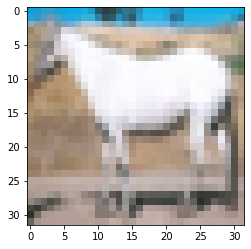

In [48]:
plt.imshow(
    torch.tensor(test_ref_data_h0[0][10].numpy()* STD[:, None, None].numpy() + MEAN[:, None, None].numpy()).permute(1, 2, 0)
)
plt.show()

In [49]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

pred = torch.argmax(model_aug(test_ref_data_h0[0][10][None, ...].to(device)), dim=-1)
print(f"Prediction:{classes[pred.item()]}")

Prediction:horse


Applying some pertubation to original image and checking the predictions

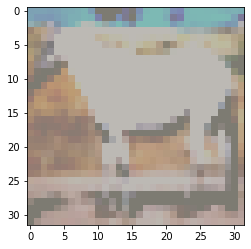

In [52]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=0.2,
    contrast_limit=0.2,
    p=0.5
)

perturbed_image = torch.tensor(perturb(image=test_ref_data_h0[0][10].numpy(),)['image'])

plt.imshow(
    (perturbed_image* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0)
)
plt.show()

In [53]:
pred = torch.argmax(model_aug(perturbed_image[None, ...].to(device)), dim=-1)
print(f"Prediction:{classes[pred.item()]}")

Prediction:horse


Checking if the data has dfrited for the original test set **test_ref_data_h0** by comparing with reference **test_ref_data_aug**

In [54]:
cd.predict(test_ref_data_h0[0][:100])

{'data': {'is_drift': 1,
  'distance': 0.016662895679473877,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00392514, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is **Some Drift!!!**

Checking if the data has dfrited after applying random brighness and contrast to  **test_ref_data_h0**

In [55]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=0.2,
    contrast_limit=0.2,
    p=0.5
)

In [42]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

Pertubed image

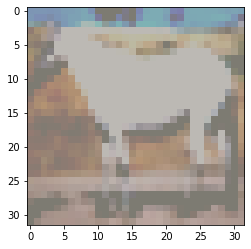

In [56]:
plt.imshow((perturbed_images[10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

original image

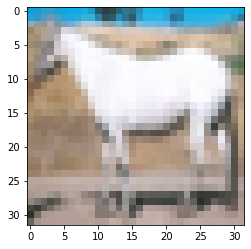

In [57]:
plt.imshow((test_ref_data_h0[0][10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

In [58]:
cd.predict(perturbed_images[:100], return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': 0.002732396125793457,
  'p_val': 0.1899999976158142,
  'threshold': 0.05,
  'distance_threshold': array(0.00803816, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is **No drift** in data here

Applying some Noise and checking for drift

In [67]:
perturb = A.GaussNoise(p=0.2)
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

Pertubed image

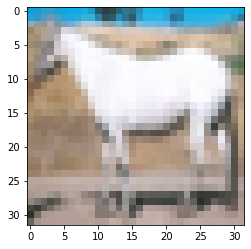

In [68]:
plt.imshow((perturbed_images[10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

original image

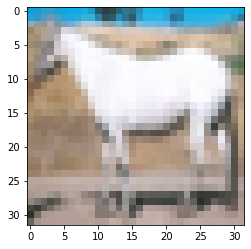

In [69]:
plt.imshow((test_ref_data_h0[0][10]* STD[:, None, None] + MEAN[:, None, None]).permute(1, 2, 0))

In [70]:
cd.predict(perturbed_images[:100])

{'data': {'is_drift': 0,
  'distance': 0.00028818845748901367,
  'p_val': 0.33000001311302185,
  'threshold': 0.05,
  'distance_threshold': array(0.00526458, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

There is **No Drift**

In [ ]:
# grid = torchvision.utils.make_grid(perturbed_images* STD[:, None, None] + MEAN[:, None, None], nrow=10)
# plt.figure(figsize=(20,20))
# plt.imshow(np.transpose(grid, (1,2,0)))